## In this notebook...

### we train a prototypical network...  

We use the classifier pretrained in the other notebook (or we could just train a model from scratch, but life is too short) as an encoder. We then train it as a prototypical network, with a view towards an epic 32k-way classification later.

### what's a prototypical network again ? 

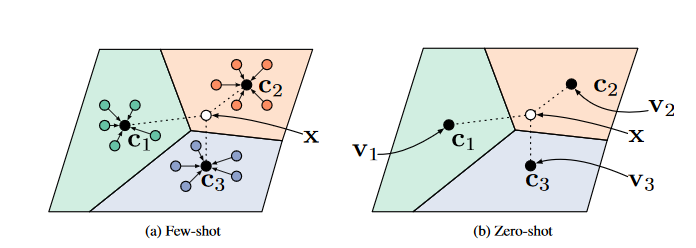

The idea is that there is an embedding space in which points belonging to a class form a cluster of sort, so this cluster/class can be represented by a prototype vector in this embedding space. This prototype vector can be for example the mean of the support vectors of the class/cluster in the embedding space. Classification of a new data point is then performed by simply finding the prototype nearest to the point in question, as demonstrated in the illustration. This can be done in few-shot classification where the few samples form the support or in zero-shot where I suppose the class prototypes would have to be determined beforehand with metadata (?).

So Prototypical Networks are networks trained to give rise to class prototypes I suppose.

### how is it trained? 

It's trained in episodes. So for each episode:
* select $N_C$ classes to then sample from
* for each class in the $N_C$ classes, select $N_{support}$ samples for a support set, select $N_{query}$ samples from the remaining set.
* compute class prototypes from support sets.

We then take the cross entropy loss over the distances between the prototypes and the actual data points. Vectorization works better in the actual implementation.

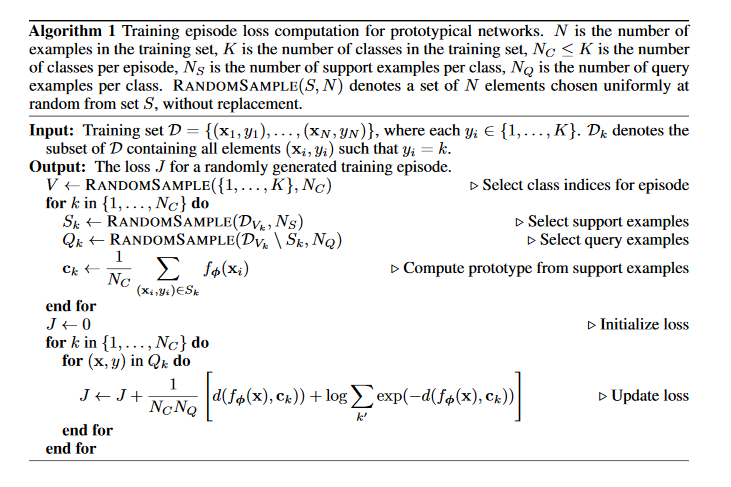

### into the workings... 

In [1]:
import os 
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ['CUDA_VISIBLE_DEVICES']='3'
os.environ['OMP_NUM_THREADS'] = '6'
os.environ['MKL_NUM_THREADS'] = '6'

In [3]:
import numpy as np                                    # Array, Linear Algebra
from torch.utils.data.dataset import random_split     # spliting inTrain Val
import pandas as pd                                   # handling CSV
import os                                             # For File handling
import random                                         # Choosing from images dataset
import time                                           # timing Epochs  
from tqdm.notebook import tqdm                        # Testing
from os.path import join                              # File Handling
from torchvision import transforms                    # Data Aug
import torch                                          # Framework
from PIL import Image                                 # Loading Image
from torch.utils.data import Dataset, DataLoader      # Dataset
import torch.nn.functional as F                       # Function
import json                                           # Loading Metadat
from PIL import  ImageOps                             # Data Aug 
from PIL.Image import open as openIm                  # Image Handling
import matplotlib.pyplot  as plt                      # Ploting Image
import cv2
from sklearn.metrics import f1_score
import seaborn as sns
from datetime import datetime

Include the following line to import the functions from few_shot

In [4]:
import sys
sys.path.append('./few_shot/')


In [5]:
"""
Reproduce Omniglot results of Snell et al Prototypical networks.
"""
from torch.optim import Adam
from torch.utils.data import DataLoader
import argparse

from few_shot.datasets import OmniglotDataset, MiniImageNet
from few_shot.models import get_few_shot_encoder
from few_shot.core import NShotTaskSampler, EvaluateFewShot, prepare_nshot_task
from few_shot.proto import proto_net_episode
from few_shot.train import fit
from few_shot.callbacks import *
from few_shot.utils import setup_dirs
from config import PATH


In [6]:
'''
import vision stuff
'''
import torchvision
import torch.nn as nn

#### add directories and load metadata 

In [7]:
#base_dir = '/bigdata/user/hieunt124/kaggle/herbarium/'
base_dir = 'D:/Data/Kaggle_HerbariumChallenge2020'
train_dir = base_dir + '/nybg2020/train/'
test_dir = base_dir + '/nybg2020/test/'
metadata_file = 'metadata.json'

In [8]:

with open(train_dir + metadata_file, encoding = "ISO-8859-1") as json_file:
    train_metadata = json.load(json_file)

train_img = pd.DataFrame(train_metadata['images'])
train_label = pd.DataFrame(train_metadata['annotations'])
train_df = (pd.merge(train_label, train_img
                    #, left_on='image_id'
                    , on='id'
                    , how='left')
            .drop(['image_id', 'license', 'region_id'], axis=1)
            .sort_values(by=['category_id'])
           )
train_df.head()

,category_id,id,file_name,height,width
76407,0,626762,images/000/00/626762.jpg,1000,681
601590,0,72077,images/000/00/72077.jpg,1000,681
76408,0,818271,images/000/00/818271.jpg,1000,681
556748,0,495523,images/000/00/495523.jpg,1000,681
335261,0,437000,images/000/00/437000.jpg,1000,681


In [9]:
train_df.rename(columns={'category_id': 'class_id'
                        , 'file_name': 'filepath'
                        }, inplace=True)

#### set training hyperparameters

We would like to make the training phase as similar to the actual problem as much as possible. To that end, we'll phrase each episode as a 1-shot, k-way with q-query problem. This will correspond to the hyperparams n, k, q. The distance function will remain the Euclidean distance as in the paper. 1-shot because some classes will have only 

To best resemble the actual problem (and as supported by the paper in regards to performance in general), the number of classes in the support set should be as high as possible. I reckon this is partly why the simpler ResNet did better in the end than SeResNet, as there was more room to scale k quite a bit higher. 

Similarly to the pre-training phase, we can also fine-tune the model on higher resolution and therefore with lower k.

In [10]:
setup_dirs()
assert torch.cuda.is_available()
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True


##############
# Parameters #
##############
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='miniImageNet')
parser.add_argument('--distance', default='l2')
parser.add_argument('--n-train', default=5, type=int)
parser.add_argument('--n-test', default=5, type=int)
parser.add_argument('--k-train', default=20, type=int)
parser.add_argument('--k-test', default=5, type=int)
parser.add_argument('--q-train', default=15, type=int)
parser.add_argument('--q-test', default=1, type=int)
args = parser.parse_args('')

#### key is to get k_train as large as possible 

In [11]:
args.dataset = 'Herbarium'
args.q_train = 1
args.q_test = 1
args.n_train = 1
args.n_test = 1
args.k_train = 15 #30
args.k_test = 5


### define dataset objects

I wanted to try augmentations from albumentations vs fastai here. At the time, I wasn't as familiar with albumentations so I just ended up with fastai. 

In [13]:
import albumentations as A
def load_rgb_image(image_file):
    '''
    load image file in RGB format
    '''
    img = cv2.imread(str(image_file))
    try:
        #img = img.astype('uint8')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as error:
        print(error)
        print(image_file)
        print(img.shape)
    return img

def get_augmentations(re_size=300#224
                      , crop_size=300#224
                      , train=True
                     ):
    '''
    get image augmentations from albumentations
    '''
    augs = [A.Resize(height=re_size, width=re_size)]
    if train:
        augs.extend([A.RandomCrop(height=crop_size, width=crop_size)
                     , A.ShiftScaleRotate(shift_limit=.1, scale_limit=.3, rotate_limit=30, p=.75)
                     #, A.RandomBrightnessContrast(brightness_limit=.5, contrast_limit=.5, p=.5)
                     , A.RandomBrightnessContrast(brightness_limit=.3, contrast_limit=.3, p=.15)
                     #, A.Blur(.5)
                     , A.Cutout(max_h_size=crop_size//12, max_w_size=crop_size//12, p=.75)
                    ])
    else:
        augs.extend([A.CenterCrop(height=crop_size, width=crop_size)])
    
    # A.Normalize uses Imagenet stats by default
    return A.Compose(augs + [A.Normalize()])

As per usual for PyTorch stuff, we define a Dataset to feed into the training process. 

In [14]:
class myHerbariumDataset(Dataset
                        ):
    def __init__(self, df_image
                         , train=True
                         , base_folder='../kaggle/herbarium/'):
        if (train):
            df_image.index = df_image['id']

        self.df = df_image ## dataframe of all image annotations
        self.datasetid_to_filepath = df_image.to_dict()['filepath']  ## get file path from image id
        self.datasetid_to_class_id = df_image.to_dict()['class_id']  ## get class id from image id

        self.classes = self.df['class_id'].unique() ## list of labels
        self.base_folder = base_folder
        self.loader = lambda x: load_rgb_image(base_folder + x)  ## loader function for the image
        self.transform = get_augmentations(train=train) ## transform the image
        self.to_tensor = transforms.ToTensor()  ## transform image to Torch tensor
        
        self.fastai_transforms = get_transforms(flip_vert=True)
        self.fastai_loader = lambda x: get_fastai_img(base_folder + x, self.fastai_transforms)
        
    def __getitem__(self, item):
        '''
        input item id, output the image and its label
        '''
        
        #image = self.loader(self.datasetid_to_filepath[item])
        #image = self.transform(image=image)['image']
        #image = self.to_tensor(image)
        image = self.fastai_loader(self.datasetid_to_filepath[item])
        label = self.datasetid_to_class_id[item]
        
        return image, label
        
        
    def __len__(self):
        '''
        returns size of dataset
        '''
        return len(self.df)
    
    def num_classes(self):
        '''
        returns number of classes
        '''
        return len(self.classes)
    
    def classes_value_counts(self):
        '''
        return number of samples per class
        '''
        return self.df.Label.value_counts().reset_index()

In [15]:
from fastai.vision import get_transforms, open_image, imagenet_stats
fastai_transforms = get_transforms(flip_vert=True)
def get_fastai_img(path, fastai_transforms
                   , img_size=256):
    '''
    '''
    fastai_img = open_image(path)
    fastai_img = fastai_img.apply_tfms(*(fastai_transforms))
    fastai_img = fastai_img.resize(img_size).px
    fastai_img = transforms.Normalize(mean=imagenet_stats[0], std=imagenet_stats[1])(fastai_img)
    
    return fastai_img

I thought I could incorporate mixup but didn't make it work. Didn't quite make sense in the context of support and query.

In [16]:
from torch.distributions.beta import Beta
def generate_mixup_samples(samples, labels, beta_distribution):
    '''
    generate mixup samples from 1 batch of samples, labels 
    and a pre-defined beta_distribution
    '''
    temp_batch_size = len(labels)
    beta_weights = beta_distribution.sample((temp_batch_size,))
    shuffled_index = torch.randperm(temp_batch_size)
    samples_shuffled = samples[shuffled_index]
    labels_shuffled = labels[shuffled_index]
    
    samples_mixup = torch.stack([beta_weights[i] * samples[i] 
                                 + (1 - beta_weights[i]) * samples_shuffled[i]
                                 for i in range(temp_batch_size)])
    labels_mixup = torch.stack([labels.float()
                                , labels_shuffled.float()
                                , beta_weights 
                               ])
    return samples_mixup, labels_mixup

class DataLoader_mixup(DataLoader):
    '''
    wrapper for DataLoader for mixup training:
    for each batch, generate mixup samples
    '''
    def __init__(self, **kwargs
                ):
        super().__init__(**kwargs)
        #self.dl = dl
        self.beta_distribution = Beta(.4,.4)
        
    #def __len__(self):
    #    return len(self)

    def __iter__(self):
        #batches = iter(self)
        for samples, labels in self:
            yield (generate_mixup_samples(samples, labels
                                          , beta_distribution=self.beta_distribution)
                  )

class CrossEntropyLoss_mixup(nn.Module):
    '''
    wrapper of CrossEntropyLoss for mixup
    using mixup while training and usual loss when evaluating
    '''
    
    def __init__(self, loss, reduction='mean'):
        super().__init__()
        self.loss_function = loss
        self.reduction = reduction
        setattr(self.loss_function, 'reduction', 'none')
        
    def forward(self, output, labels_mixup):
        if len(labels_mixup.shape) != 1:
            # mixup training mode
            labels = labels_mixup[0,:].long()
            labels_shuffled = labels_mixup[1,:].long()
            beta_weights = labels_mixup[2,:]
            
            loss = (beta_weights * self.loss_function(output, labels)
                   + (1-beta_weights) * self.loss_function(output, labels_shuffled)
                   )
            
        else:
            # evaluation mode, return loss as usual
            loss = self.loss_function(output, labels_mixup)
        
        if self.reduction == 'mean': 
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss

We'll extract the classes that only have 1 sample here, they'll be excluded from training. This is just to make sure support and query can sample from the same set of classes.

In [17]:
label_counts = pd.DataFrame(train_df.class_id.value_counts().reset_index()
                           )
label_counts.columns = ['class_id','count_samples']
single_categories = label_counts[label_counts['count_samples'] < 2].class_id.values
quarter_categories = label_counts[label_counts['count_samples'] > 4].class_id.values


In [18]:
high_sample_categories = label_counts[label_counts['count_samples'] > 200].class_id.values

Having defined the Dataset class, we can then define the corresponding data loaders. The number of episodes is taken to be roughly the number of total classes divided by number of classes sampled for each episode.

In [19]:
from sklearn.model_selection import train_test_split
_, val_subset = train_test_split(#train_df[train_df.class_id.isin(quarter_categories)]
                                train_df[train_df.class_id.isin(high_sample_categories)]
                                 , test_size=.005 #originally .05
                                )
val_subset.shape

(1656, 5)

Again, just making sure that all classes in the validation set has at least 2 samples...

In [20]:
#val_classes = val_subset.class_id.value_counts()[:8000].index.tolist()
val_classes = val_subset.class_id.value_counts()[:100].index.tolist()
val_subset = val_subset[val_subset.class_id.isin(val_classes)]

In [21]:
train_filter = ((train_df.class_id.isin(single_categories))
               | (train_df.id.isin(val_subset.id))
               )
train_subset = train_df[-train_filter]
train_subset = train_subset[train_subset.class_id.isin(high_sample_categories)]
train_subset.shape

(330690, 5)

### setting up the training process 

The number of episodes is taken to be roughly the number of total classes divided by number of classes sampled for each episode.

In [22]:
evaluation_episodes = 10 #1000
episodes_per_epoch = 300 #800 # how many episodes to roughly cover the classes

if args.dataset == 'omniglot':
    n_epochs = 40
    dataset_class = OmniglotDataset
    num_input_channels = 1
    drop_lr_every = 20
elif args.dataset == 'miniImageNet':
    n_epochs = 35 #120
    dataset_class = MiniImageNet
    num_input_channels = 3
    drop_lr_every = 40
else:
    n_epochs = 48 #120
    #dataset_class = MiniImageNet
    num_input_channels = 3
    drop_lr_every = 24
    #raise(ValueError, 'Unsupported dataset')

param_str = f'{args.dataset}_nt={args.n_train}_kt={args.k_train}_qt={args.q_train}_' \
            f'nv={args.n_test}_kv={args.k_test}_qv={args.q_test}_toyresnet50'

print(param_str)

###################
# Create datasets #
###################
#background = dataset_class('background')
background = myHerbariumDataset(train_subset
                                , train=True
                                , base_folder=train_dir 
                               )
background_taskloader = DataLoader(
    background,
    batch_sampler=NShotTaskSampler(background, episodes_per_epoch, args.n_train, args.k_train, args.q_train),
    num_workers=0
)
#background_taskloader = DataLoader_mixup(background_taskloader, Beta(.4,.4))
evaluation = myHerbariumDataset(val_subset#.reset_index(drop=True)
                                , train=True
                                , base_folder=train_dir 
                               )
evaluation_taskloader = DataLoader(
    evaluation,
    batch_sampler=NShotTaskSampler(evaluation, episodes_per_epoch, args.n_test, args.k_test, args.q_test),
    num_workers=0
)



Herbarium_nt=1_kt=15_qt=1_nv=1_kv=5_qv=1_toyresnet50


### set up the model 

We basically recycle the code for the model architecture used in the pretraining notebook here. We load the weights, then drop the last softmax layer, using only up to the second-last layer as an encoder.

A note on the encoder structure, I tried (with limited architectures) both the original arch and the arch topped by a fastai head as encoders and found that it seems better to have the fastai head. Go figure.

In [23]:
from fastai.layers import AdaptiveConcatPool2d, Flatten

In [30]:
def ResnetProtoTypeNet():
    
    def my_head(input_size, hidden_units, output_size):
        return nn.Sequential(AdaptiveConcatPool2d()
                                        , Flatten()
                                        , nn.BatchNorm1d(num_features=2 * input_size)
                                        , nn.Dropout(p=.25)
                                        , nn.Linear(in_features=2 * input_size, out_features=hidden_units, bias=True)
                                        , nn.ReLU(inplace=True)
                                        , nn.BatchNorm1d(num_features=hidden_units)
                                        , nn.Dropout(p=.5)
                                        , nn.Linear(in_features=hidden_units, out_features=output_size, bias=True)
                                        
                                       )

    arch = torchvision.models.resnet50(pretrained=False)
    #arch = se_resnet101(pretrained=None)
    arch = list(arch.children())
    arch.pop(-1)
    arch.pop(-1)
    temp_arch = nn.Sequential(nn.Sequential(*arch))
    temp_children = list(temp_arch.children())
    temp_children.append(my_head(2048, 512, 10))
    model = nn.Sequential(*temp_children)
    
    model_dir = 'models/'
    model_file = 'herbarium-toy-resnet50-10-weights.pth'
    weights = torch.load(model_dir + model_file)

    model.load_state_dict(weights['state_dict'])
    
    temp_head = list(model.children())[-1]
    temp_head = nn.Sequential(*list(temp_head.children())[:-2])
    #temp_head = nn.Sequential(*list(temp_head.children())[:2])
    temp_arch = nn.Sequential(nn.Sequential(*list(model.children())[:-1]))
    model = nn.Sequential(temp_arch, temp_head)
    
    return model
    #return temp_arch

In [31]:

#########
# Model #
#########
#model = get_few_shot_encoder(num_input_channels)
#model.to(device, dtype=torch.double)
model = ResnetProtoTypeNet()
model.to(device, dtype=torch.float)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

With the ADAM optimizer and Negative log-likelihood loss function:

I make a mistake here in one of the runs here, using CrossEntropy loss instead of NLLLoss, effectively piling 2 softmaxes then a NLLLoss. Still turns out ok for some reason, deep learning is weird.

In [33]:

############
# Training #
############
print(f'Training Prototypical network on {args.dataset}...')
optimiser = Adam(model.parameters(), lr=1e-4)
#loss_fn = torch.nn.NLLLoss().cuda()
loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = CrossEntropyLoss_mixup(loss_fn)

def lr_schedule(epoch, lr):
    # Drop lr every 2000 episodes
    if epoch % drop_lr_every == 0:
        return lr * 0.6
    else:
        return lr


Training Prototypical network on Herbarium...


In [35]:

callbacks = [
    EvaluateFewShot(
        eval_fn=proto_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=args.n_test,
        k_way=args.k_test,
        q_queries=args.q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(args.n_test, args.k_test, args.q_test),
        distance=args.distance
    ),
    ModelCheckpoint(
        filepath=PATH + f'/models/proto_nets/{param_str}.pth',
        monitor=f'val_{args.n_test}-shot_{args.k_test}-way_acc'
    ),
    LearningRateScheduler(schedule=lr_schedule),
    CSVLogger(PATH + f'/logs/proto_nets/{param_str}.csv'),
]

In [36]:
n_epochs=8

In [38]:

fit(
    model,
    optimiser,
    loss_fn,
    epochs=n_epochs,
    dataloader=background_taskloader,
    prepare_batch=prepare_nshot_task(args.n_train, args.k_train, args.q_train),
    callbacks=callbacks,
    metrics=['categorical_accuracy'],
    fit_function=proto_net_episode,
    fit_function_kwargs={'n_shot': args.n_train, 'k_way': args.k_train, 'q_queries': args.q_train, 'train': True,
                         'distance': args.distance}
)

Epoch 1:   0%|                                                                                 | 0/300 [00:00<?, ?it/s]

Begin training...


Epoch 8: 100%|████████████████████████████████| 300/300 [33:38<00:00,  6.73s/it, loss=18.5, categorical_accuracy=0.511]

Finished.


For a toy model on a toy training phase, it should look something like this.

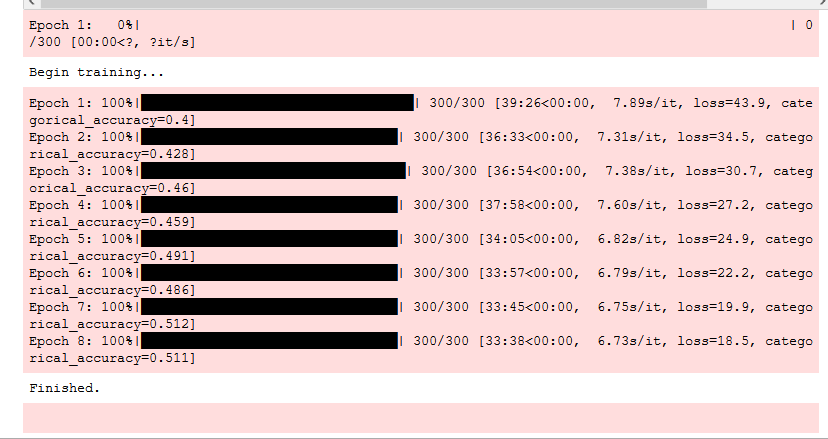

For a more serious model, with k in the 50-60s, 800 episodes, expect a better performance

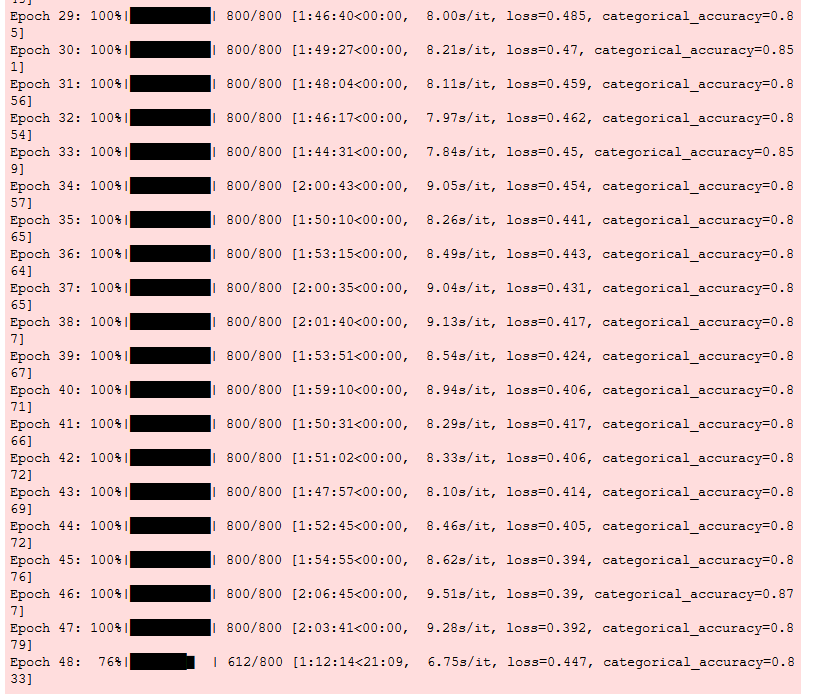